In [1]:
import proplot as pplt
import numpy as np
from mdet_tools import meas_m, meas_mbmeds, make_obs

%load_ext autoreload
%autoreload 2

In [3]:
n_stars = 20
m, merr, c, cerr, _, _ = meas_m(n_stars=n_stars, mask_width=2, seed=20, n_jobs=10)

print("\nstar density: %s [num per arcmin^2]" % (n_stars / (235*0.20/60)**2))
mstr = "m +/- merr: %0.6f +/- %0.6f [10^(-3), 3sigma]" % (m/1e-3, 3*merr/1e-3)
print(mstr)

cstr = "c +/- cerr: %0.6f +/- %0.6f [10^(-5), 3sigma]" % (c/1e-3, 3*cerr/1e-3)
print(cstr)

100%|██████████████████████████████████████████| 10/10 [00:15<00:00,  1.60s/it]


star density: 32.593933906745136 [num per arcmin^2]
m +/- merr: 27.196766 +/- 75.950800 [10^(-3), 3sigma]
c +/- cerr: 22.801355 +/- 2746.436907 [10^(-5), 3sigma]


((0.0, 275.0), (0.0, 275.0), (0.0, 275.0))

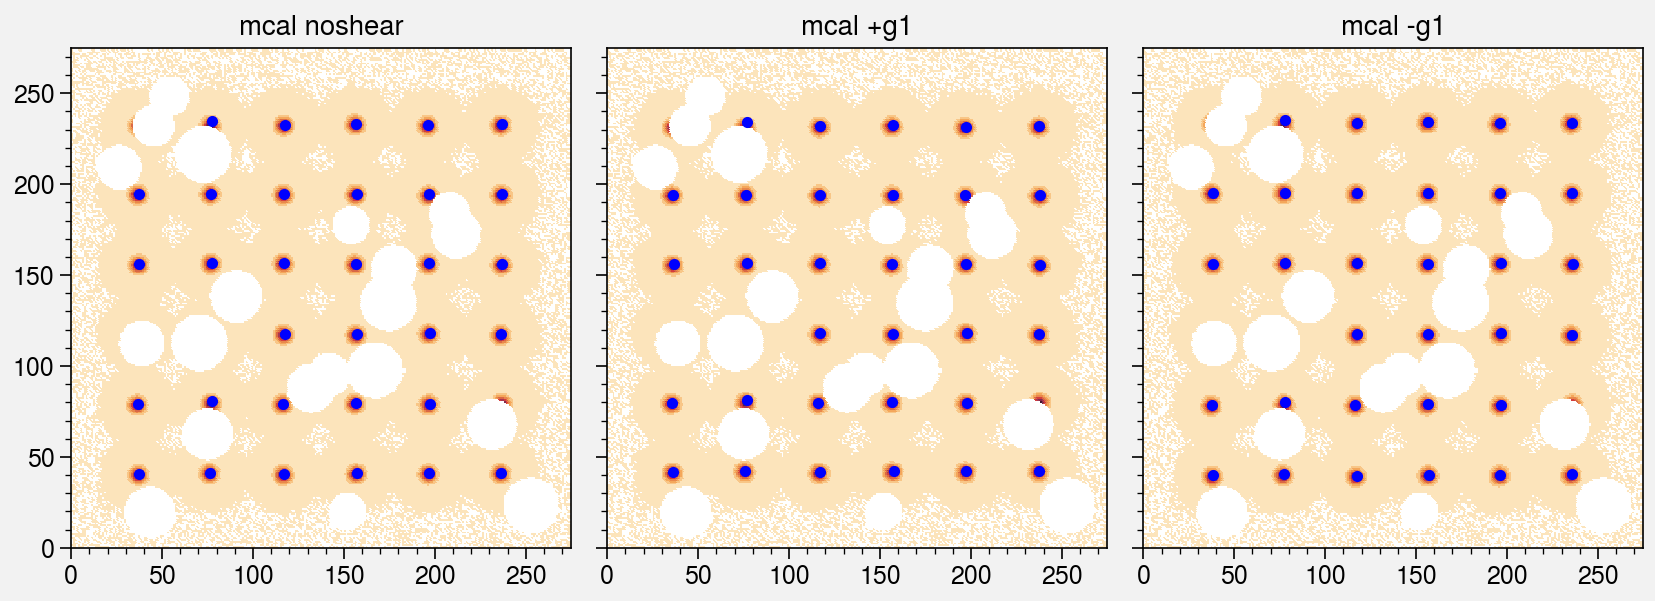

In [7]:
n_stars = 20
step = 0.01
s = 10
kwargs = {"n_stars": n_stars, "seed": s}
d, mbobs = meas_mbmeds(make_obs(mcal_shear=(0, 0), **kwargs), mask_width=2)
d1p, mbobs1p = meas_mbmeds(make_obs(mcal_shear=(step, 0), **kwargs), mask_width=2)
d1m, mbobs1m = meas_mbmeds(make_obs(mcal_shear=(-step, 0), **kwargs), mask_width=2)

fig, axs = pplt.subplots(nrows=1, ncols=3, sharex=3, sharey=3)
axs[0].pcolormesh(mbobs[0][0].image)
axs[0].plot(d["x"], d["y"], '.b')
axs[0].set_title("mcal noshear")

axs[1].pcolormesh(mbobs1p[0][0].image)
axs[1].plot(d1p["x"], d1p["y"], '.b')
axs[1].set_title("mcal +g1")

axs[2].pcolormesh(mbobs1m[0][0].image)
axs[2].plot(d1m["x"], d1m["y"], '.b')
axs[2].set_title("mcal -g1")

axs.set_xlim(0, mbobs[0][0].image.shape[1])
axs.set_ylim(0, mbobs[0][0].image.shape[0])

In [8]:
d

array([(0,  0.0083718 , -4.55372314e-07, 923680.12471748, 236.68270852, 117.46250369, 1.51816237),
       (0,  0.00859284,  4.89633678e-05, 923435.78440911,  76.57819483,  41.26420533, 1.51787686),
       (0,  0.00851407,  1.24870328e-04, 923356.74682019,  37.3513601 ,  40.73328695, 1.51790522),
       (0,  0.00837314,  1.62739797e-06, 923679.21977277, 196.93553918,  41.06914102, 1.5181642 ),
       (0,  0.00837192, -4.73870676e-07, 923679.23117762, 197.1259671 ,  79.21347895, 1.51816225),
       (0,  0.10946329, -3.07235653e-02, 857432.66313151,  77.45786099,  80.74659473, 1.39782937),
       (0,  0.00045148, -1.11228531e-02, 916179.69069496, 116.34190595,  79.09106111, 1.49870304),
       (0,  0.00837249,  4.75816472e-07, 923680.77339147, 117.33985389, 117.69904002, 1.51815985),
       (0,  0.00560928, -1.03548873e-03, 922096.86101624, 196.99445757, 156.50941276, 1.51381565),
       (0, -0.00910545,  4.77558297e-02, 896517.51691829, 196.55608098, 194.52739308, 1.45445083),
       (0,

In [125]:
import galsim
import ngmix
from ngmix.gaussmom import GaussMom

def meas_one_im(*, g1, g2, mask_delta1, mask_delta2, rotate, symdelta=0):
    obj = galsim.Exponential(half_light_radius=0.5).shear(g1=g1, g2=g2)
    psf = galsim.Gaussian(fwhm=0.9)
    obj = galsim.Convolve([obj, psf])
    dim = 53
    cen = (dim-1)//2
    im = obj.drawImage(nx=dim, ny=dim, scale=0.2).array
    psf_im = psf.drawImage(nx=dim, ny=dim, scale=0.2).array
    jac = ngmix.DiagonalJacobian(scale=0.2, row=cen, col=cen)
    psf_obs = ngmix.Observation(
        image=psf_im,
        weight=np.ones_like(psf_im),
        jacobian=jac,
    )
    wgt = np.ones_like(im)
    if mask_delta1 is not None:
        wgt[:, cen+mask_delta1:] = 0
        if rotate:
            wgt[cen+mask_delta1+symdelta:, :] = 0
    if mask_delta2 is not None:
        wgt[cen+mask_delta2:, :] = 0
        if rotate:
            wgt[:, cen+mask_delta2+symdelta:] = 0
    obs = ngmix.Observation(
        image=im,
        weight=wgt,
        jacobian=jac,
        psf=psf_obs
    )
    mom = GaussMom(fwhm=1.2, obs=obs)
    mom.go()
    res = mom.result
    
    gauss_wgt = ngmix.GMixModel(
        [0, 0, 0, 0, ngmix.moments.fwhm_to_T(1.2), 1],
        'gauss',
    )    
    cobs = obs.copy()
    cobs.image = 1.0 - wgt
    cobs.weight = np.ones_like(wgt)
    stats = gauss_wgt.get_weighted_sums(
        cobs,
        1.2 * 2,
    )    
    mfrac = stats["sums"][5] / stats["wsum"]
    return res["e"][0], res["e"][1], obs, mfrac

In [126]:
def meas_R_mask(mask_delta1, rotate, symdelta=0):
    e1 = []
    shear = np.linspace(0, 0.06, 50)
    for s in shear:
        e1.append(meas_one_im(
            g1=s, g2=0, mask_delta1=mask_delta1, mask_delta2=None, 
            rotate=rotate, symdelta=symdelta
        )[0])
    e1 = np.array(e1)
    R = (e1[1:] - e1[:-1])/(shear[1:] - shear[:-1])
    sp = (shear[1:] + shear[:-1])/2
    ds = sp[1] - sp[0]
    R0 = (
        meas_one_im(
            g1=ds, g2=0, mask_delta1=mask_delta1, mask_delta2=None, 
            rotate=rotate, symdelta=symdelta
        )[0] 
        - meas_one_im(
            g1=-ds, g2=0, mask_delta1=mask_delta1, mask_delta2=None, 
            rotate=rotate, symdelta=symdelta
        )[0]
    )/2/ds
    sp = np.concatenate([np.array([0]), sp])
    R = np.concatenate([np.array([R0]), R])
    mfrac = meas_one_im(
        g1=s, g2=0, mask_delta1=mask_delta1, mask_delta2=None, 
        rotate=rotate, symdelta=symdelta
    )[-1]
    
    return sp, R, mfrac

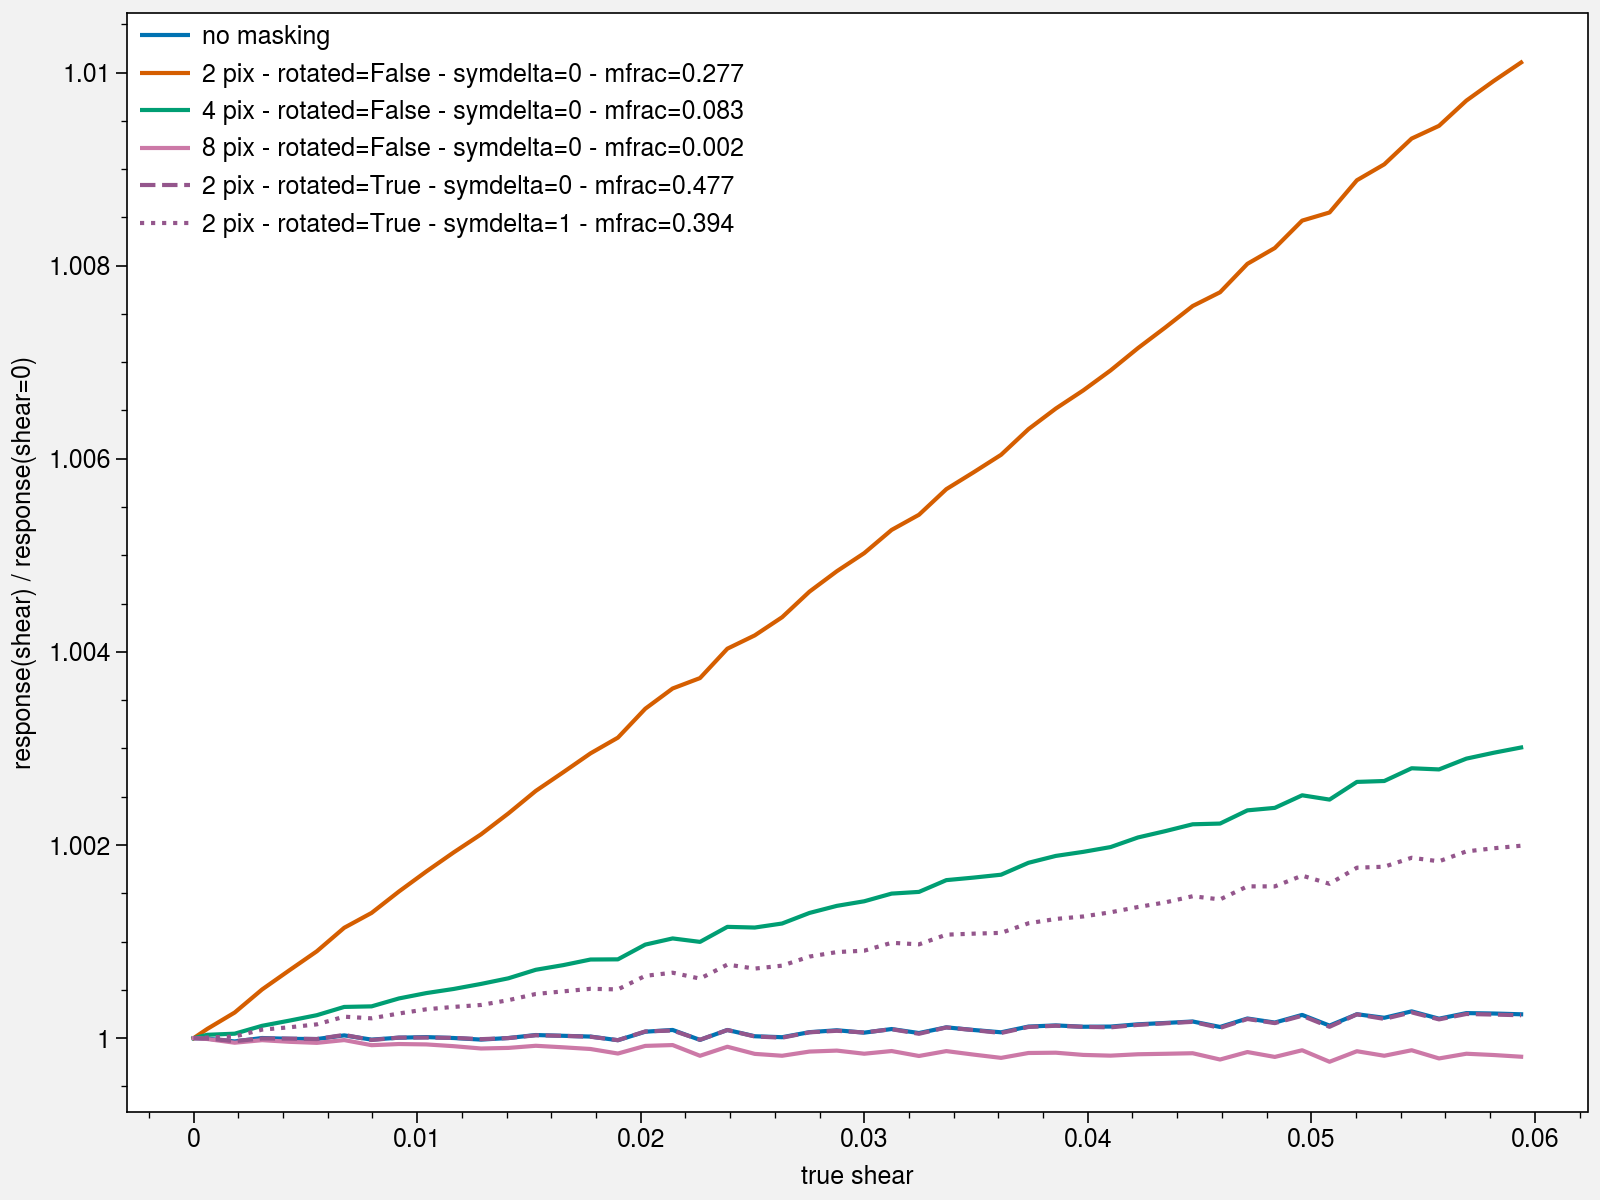

In [127]:
def _do_plots(axs, rotate, symdelta, pixvals, **kwargs):
    hdls = []
    for pval in pixvals:
        if pval is None:
            sp, R, mf = meas_R_mask(None, rotate, symdelta=symdelta)
            hdls.append(axs.plot(sp, R/R[0], label='no masking'))
        else:
            sp, R, mf = meas_R_mask(pval, rotate, symdelta=symdelta)
            hdls.append(axs.plot(
                    sp, R/R[0], 
                    label='%d pix - rotated=%s - symdelta=%d - mfrac=%0.3f' % (pval, rotate, symdelta, mf), 
                    **kwargs
                )
            )

    return hdls

fig, axs = pplt.subplots(figsize=(8, 6))

hdls = _do_plots(axs, False, 0, [None, 2, 4, 8])
hdls.extend(_do_plots(axs, True, 0, [2], linestyle='dashed', color='purple'))
hdls.extend(_do_plots(axs, True, 1, [2], linestyle='dotted', color='purple'))

axs.legend(hdls, loc='ul', ncols=1, frameon=False, framealpha=0)
axs.format(xlabel='true shear')
axs.format(ylabel='response(shear) / response(shear=0)')
axs.grid(False)

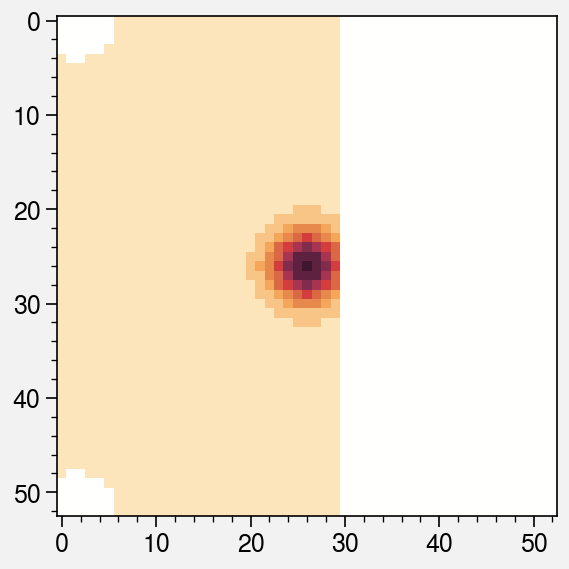

In [63]:
obs = meas_one_im(g1=0.02, g2=0, mask_delta1=4, mask_delta2=None, rotate=False)[-1]

fig, axs = pplt.subplots()
axs.imshow(obs.image * obs.weight)
axs.grid(False)